# Dealing with dimensions in classification

## Running example

<table>
    <tr>
        <th></th>
        <th>DocID</th>
        <th>Tokens</th>
        <th>E-devices</th>
    </tr>
    <tr>
        <td>Training</td>
        <td>0</td>
        <td>apple ios mac book fruit</td>
        <td>TRUE</td>
    </tr>
    <tr>
        <td>Training</td>
        <td>1</td>
        <td>apple mac book apple store fruit</td>
        <td>TRUE</td>
    </tr>
    <tr>
        <td>Training</td>
        <td>2</td>
        <td>microsoft ibm apple oracle</td>
        <td>TRUE</td>
    </tr>
    <tr>
        <td>Training</td>
        <td>3</td>
        <td>apple banana mango fruit</td>
        <td>FALSE</td>
    </tr>
    <tr>
        <td>Training</td>
        <td>4</td>
        <td>apple fruit</td>
        <td>FALSE</td>
    </tr>
    <tr style='border-top: double 2px #000000'>
        <td style='background-color: #eeee00'>Test</td>
        <td style='background-color: #eeee00'>5</td>
        <td style='background-color: #eeee00'>apple mac book fruit</td>
        <td style='background-color: #eeee00'>?</td>
    </tr>
    <tr>
        <td style='background-color: #eeee00'>Test</td>
        <td style='background-color: #eeee00'>6</td>
        <td style='background-color: #eeee00'>mac fruit color</td>
        <td style='background-color: #eeee00'>?</td>
    </tr>
</table>


In [1]:
from collections import Counter
import numpy as np
from IPython.core.display import display, HTML


def to_table(tokens, M, rnd=3):
    row = "".join(['<th>'+x+'</th>' for x in tokens])
    table = "<table><tr>"+row+"</tr>"
    for doc in M:
        row = "<tr>"+"".join(['<td>'+str(round(x, rnd))+'</td>' for x in doc])+"</tr>"
        table += row
    table += '</table>'
    display(HTML(table)) 

def model(tokens, docs):
    dictionary, tf = {}, {}
    for i, d in enumerate(docs):
        tf[i] = dict(Counter(d).most_common())
        for k in tf[i].keys():
            try:
                dictionary[k] += 1
            except KeyError:
                dictionary[k] = 1
    M = np.zeros((len(docs), len(tokens)))
    for i in range(0, len(docs)):
        for j, k in enumerate(tokens):
            try:
                M[i,j] = float(tf[i][k]) / (np.log((float(len(docs)) / dictionary[k])) + 1)
            except KeyError:
                pass
        M[i] /= np.linalg.norm(M[i])
    return M


In [2]:
training = [
    ['apple', 'ios', 'mac', 'book', 'fruit'],
    ['apple', 'mac', 'book', 'apple', 'store', 'fruit'],
    ['microsoft', 'ibm', 'apple', 'oracle'],
    ['apple', 'banana', 'mango', 'fruit'],
    ['apple', 'fruit']
]
testing = [
    ['apple', 'mac', 'book', 'fruit'],
    ['mac', 'fruit', 'color']
]
tokens = set()
for d in training + testing:
    for t in d:
        tokens.add(t)
tokens = sorted(list(tokens))

T = model(tokens, training)
X = model(tokens, testing)

In [3]:
to_table(tokens, T)

apple,banana,book,color,fruit,ibm,ios,mac,mango,microsoft,oracle,store
0.651,0.0,0.34,0.0,0.532,0.0,0.249,0.34,0.0,0.0,0.0,0.0
0.864,0.0,0.225,0.0,0.353,0.0,0.0,0.225,0.0,0.0,0.0,0.166
0.833,0.0,0.0,0.0,0.0,0.319,0.0,0.0,0.0,0.319,0.319,0.0
0.714,0.274,0.0,0.0,0.584,0.0,0.0,0.0,0.274,0.0,0.0,0.0
0.774,0.0,0.0,0.0,0.633,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
to_table(tokens, X)

apple,banana,book,color,fruit,ibm,ios,mac,mango,microsoft,oracle,store
0.36,0.0,0.36,0.0,0.609,0.0,0.0,0.609,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.385,0.652,0.0,0.0,0.652,0.0,0.0,0.0,0.0


# Rocchio

In [5]:
from scipy.spatial import distance

def rocchio(c, nc, doc, df=None):
    c_m, nc_m = np.mean(c, axis=0), np.mean(nc, axis=0)
    if df is None:
        df = distance.euclidean
    s, b = df(doc, c_m), df(doc, nc_m)
    if  s < b:
        return True, s-b
    else:
        return False, s-b

In [6]:
for i in range(0, len(testing)):
    R = rocchio(T[:3,:], T[3:,:], X[i], df=distance.euclidean)
    print " ".join(testing[i]), R

apple mac book fruit (True, -0.10150560484760196)
mac fruit color (False, 0.007562143795249554)


In [7]:
display(HTML('<h2>class</h2>'))
to_table(tokens, T[:3,:])
display(HTML('<h3>centroid</h3>'))
to_table(tokens, np.array([np.mean(T[:3,:], axis=0)]))
display(HTML('<h2>no class</h2>'))
to_table(tokens, T[3:,:])
display(HTML('<h3>centroid</h3>'))
to_table(tokens, np.array([np.mean(T[3:,:], axis=0)]))

apple,banana,book,color,fruit,ibm,ios,mac,mango,microsoft,oracle,store
0.651,0.0,0.34,0.0,0.532,0.0,0.249,0.34,0.0,0.0,0.0,0.0
0.864,0.0,0.225,0.0,0.353,0.0,0.0,0.225,0.0,0.0,0.0,0.166
0.833,0.0,0.0,0.0,0.0,0.319,0.0,0.0,0.0,0.319,0.319,0.0


apple,banana,book,color,fruit,ibm,ios,mac,mango,microsoft,oracle,store
0.783,0.0,0.188,0.0,0.295,0.106,0.083,0.188,0.0,0.106,0.106,0.055


apple,banana,book,color,fruit,ibm,ios,mac,mango,microsoft,oracle,store
0.714,0.274,0.0,0.0,0.584,0.0,0.0,0.0,0.274,0.0,0.0,0.0
0.774,0.0,0.0,0.0,0.633,0.0,0.0,0.0,0.0,0.0,0.0,0.0


apple,banana,book,color,fruit,ibm,ios,mac,mango,microsoft,oracle,store
0.744,0.137,0.0,0.0,0.608,0.0,0.0,0.0,0.137,0.0,0.0,0.0


## Understand terminology

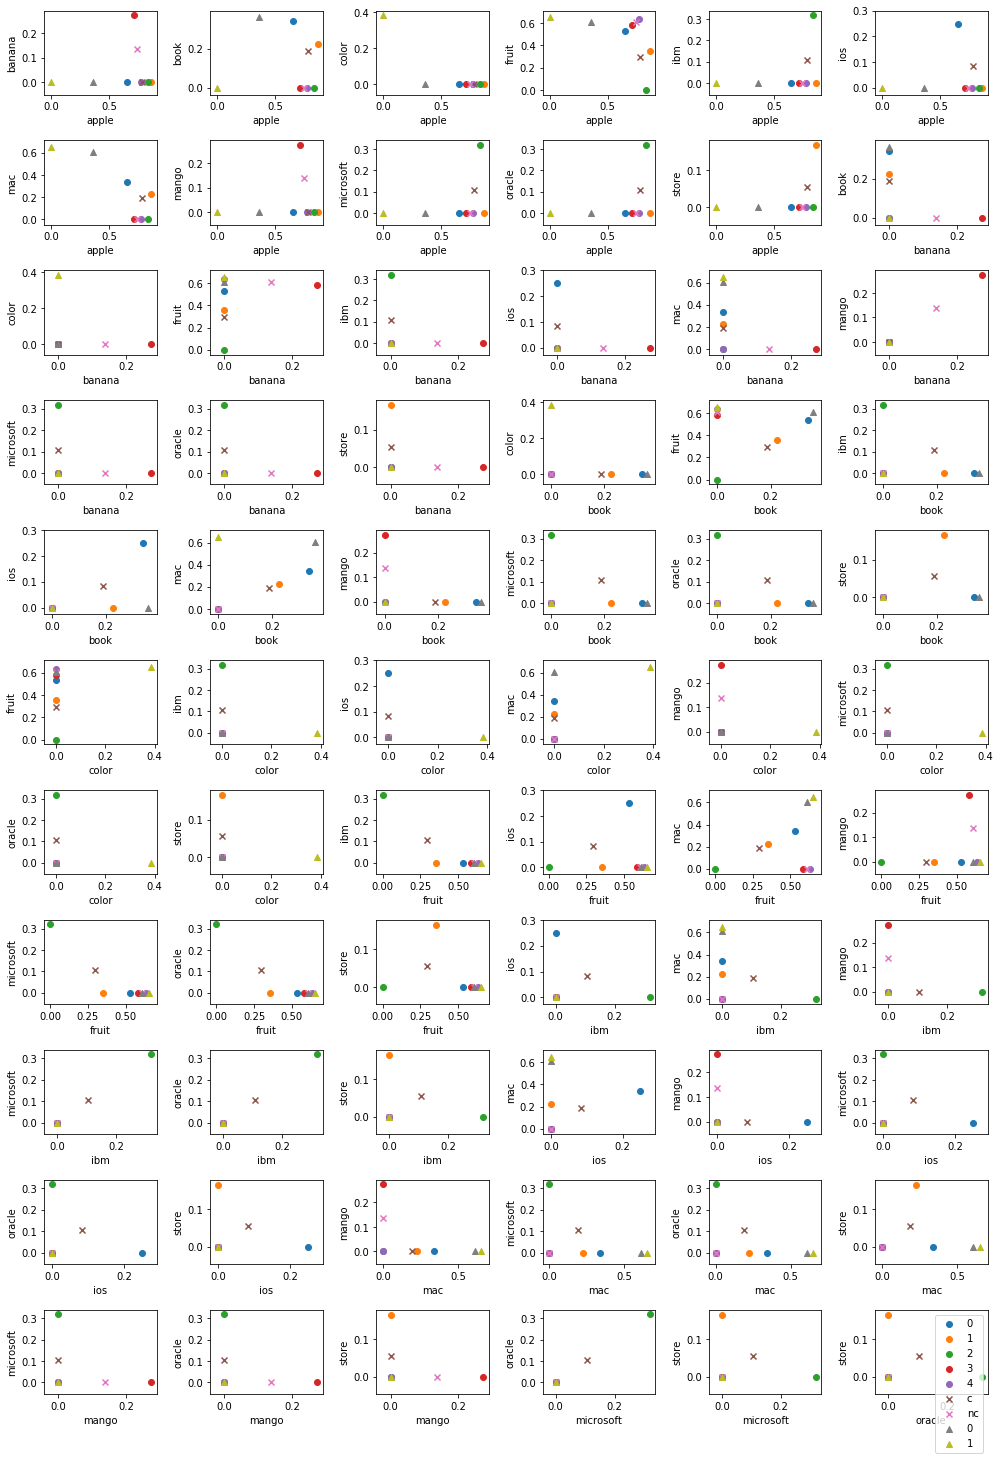

In [11]:
import matplotlib.pyplot as plt


def visualize(ax, D, labels, d1=0, d2=1, marker='o', d1l='d1', d2l='d2'):
    for d in range(0, D.shape[0]):
        ax.scatter(D[d, d1], D[d, d2], label=labels[d], marker=marker)
        ax.set_xlabel(d1l)
        ax.set_ylabel(d2l)

cmean, ncmean = np.mean(T[:3,:], axis=0), np.mean(T[3:,:], axis=0)
means = np.vstack((np.array([cmean]), np.array([ncmean])))
cols = 6
c_tokens = []
for ki, kk in enumerate(tokens):
    for kj in tokens[ki+1:]:
        c_tokens.append((kk, kj))
k = len(c_tokens)
fig, axes = plt.subplots(nrows=int(np.ceil(float(k)/cols)), ncols=cols, figsize=(14, 20))
for cl in range(0, k):
    visualize(axes[cl/cols, cl%cols], T, [str(x) for x in range(0, T.shape[0])], 
              d1=tokens.index(c_tokens[cl][0]), d2=tokens.index(c_tokens[cl][1]), 
              d1l=c_tokens[cl][0], d2l=c_tokens[cl][1])
    visualize(axes[cl/cols, cl%cols], means, ['c', 'nc'], 
              d1=tokens.index(c_tokens[cl][0]), d2=tokens.index(c_tokens[cl][1]), marker='x',
              d1l=c_tokens[cl][0], d2l=c_tokens[cl][1])
    visualize(axes[cl/cols, cl%cols], X, [str(x) for x in range(0, X.shape[0])], 
              d1=tokens.index(c_tokens[cl][0]), d2=tokens.index(c_tokens[cl][1]), marker='^',
              d1l=c_tokens[cl][0], d2l=c_tokens[cl][1])
plt.tight_layout()
axes[cl/cols, cl%cols].legend()
plt.show()


### Measuring utility

In [12]:
filtered, th = [], 0.01
for i, t in enumerate(tokens):
    v = np.var(T.T[i])
    print t, v
    if v >= th:
        filtered.append(t)
print filtered

apple 0.00602001869587
banana 0.0119755960573
book 0.0204665274163
color 0.0
fruit 0.0531181943289
ibm 0.0163112742134
ios 0.00995704256944
mac 0.0204665274163
mango 0.0119755960573
microsoft 0.0163112742134
oracle 0.0163112742134
store 0.00438397877356
['banana', 'book', 'fruit', 'ibm', 'mac', 'mango', 'microsoft', 'oracle']


In [13]:
Tf = model(filtered, training)
Xf = model(filtered, testing)

In [14]:
for i in range(0, len(testing)):
    R = rocchio(Tf[:3,:], Tf[3:,:], Xf[i], df=distance.euclidean)
    print " ".join(testing[i]), R

apple mac book fruit (True, -0.34468579233846175)
mac fruit color (True, -0.14804488328266008)


### Mutual utility

In [15]:
C = np.cov(T.T, ddof=0)

In [16]:
test = 'mac'
for i, t in enumerate(tokens):
    print test, t, C[tokens.index(test), i]

mac apple -0.00354120983626
mac banana -0.00618405504909
mac book 0.0204665274163
mac color 0.0
mac fruit 0.00456456244995
mac ibm -0.00721719969382
mac ios 0.0113094498703
mac mac 0.0204665274163
mac mango -0.00618405504909
mac microsoft -0.00721719969382
mac oracle -0.00721719969382
mac store 0.00372053670828


In [17]:
clusters, th = {}, 0.01
for i, t in enumerate(tokens):
    clusters[t] = []
    for k in tokens[i:]:
        cv = C[i, tokens.index(k)]
        if cv > th:
            clusters[t].append(k)
sets = []
for o in [x for x in clusters.values() if len(x) > 0]:
    sets.append(set(o))
sets = sorted(sets, key=lambda x: -len(x))
for s in sets:
    print s

set(['oracle', 'ibm', 'microsoft'])
set(['mac', 'book', 'ios'])
set(['oracle', 'microsoft'])
set(['mango', 'banana'])
set(['mac'])
set(['fruit'])
set(['mango'])
set(['mac'])
set(['oracle'])


In [18]:
refined = []
for s in sets:
    ins = True
    for i, k in enumerate(refined):
        if len(s.intersection(k)) > 0:
            refined[i] = s.union(k)
            ins = False
            break
    if ins:
        refined.append(s)
for s in refined:
    print s

set(['oracle', 'microsoft', 'ibm'])
set(['mac', 'book', 'ios'])
set(['mango', 'banana'])
set(['fruit'])


### Use new terminology

In [19]:
training_r = []
testing_r = []
for doc in training:
    n_doc = []
    for token in doc:
        for i, s in enumerate(refined):
            if token in s:
                n_doc.append(str(i))
                break
    training_r.append(n_doc)
for doc in testing:
    n_doc = []
    for token in doc:
        for i, s in enumerate(refined):
            if token in s:
                n_doc.append(str(i))
                break
    testing_r.append(n_doc)


In [20]:
tokens_r = set()
for d in training_r + testing_r:
    for t in d:
        tokens_r.add(t)
tokens_r = sorted(list(tokens_r))

Tr = model(tokens_r, training_r)
Xr = model(tokens_r, testing_r)

In [21]:
to_table(tokens_r, Tr)

0,1,2,3
0.0,0.886,0.0,0.463
0.0,0.787,0.0,0.617
1.0,0.0,0.0,0.0
0.0,0.0,0.684,0.73
0.0,0.0,0.0,1.0


In [22]:
to_table(tokens_r, Xr)

0,1,2,3
0.0,0.894,0.0,0.447
0.0,0.707,0.0,0.707


In [23]:
for i in range(0, len(testing_r)):
    R = rocchio(Tr[:3,:], Tr[3:,:], Xr[i], df=distance.euclidean)
    print " ".join(testing_r[i]), R

1 1 3 (True, -0.5629788508781567)
1 3 (True, -0.2971775586518077)


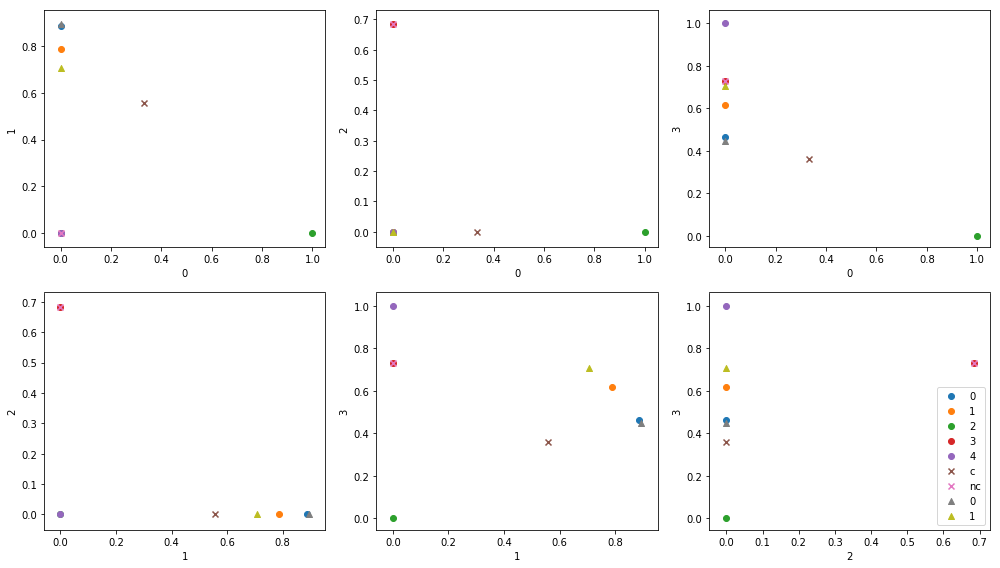

In [24]:
means = np.vstack((np.array([np.mean(Tr[:3,:], axis=0)]), np.array([Tr[3,:]])))
cols = 3
cr_tokens = []
for ki, kk in enumerate(tokens_r):
    for kj in tokens_r[ki+1:]:
        cr_tokens.append((kk, kj))
k = len(cr_tokens)
fig, axes = plt.subplots(nrows=int(np.ceil(float(k)/cols)), ncols=cols, figsize=(14, 8))
for cl in range(0, k):
    visualize(axes[cl/cols, cl%cols], Tr, [str(x) for x in range(0, Tr.shape[0])], 
              d1=tokens_r.index(cr_tokens[cl][0]), d2=tokens_r.index(cr_tokens[cl][1]), 
              d1l=cr_tokens[cl][0], d2l=cr_tokens[cl][1])
    visualize(axes[cl/cols, cl%cols], means, ['c', 'nc'], 
              d1=tokens_r.index(cr_tokens[cl][0]), d2=tokens_r.index(cr_tokens[cl][1]), 
              marker='x',
              d1l=cr_tokens[cl][0], d2l=cr_tokens[cl][1])
    visualize(axes[cl/cols, cl%cols], Xr, [str(x) for x in range(0, Xr.shape[0])], 
              d1=tokens_r.index(cr_tokens[cl][0]), d2=tokens_r.index(cr_tokens[cl][1]), 
              marker='^',
              d1l=cr_tokens[cl][0], d2l=cr_tokens[cl][1])
plt.tight_layout()
axes[cl/cols, cl%cols].legend()
plt.show()



## Better dimensionality reduction

In [25]:
w, v = np.linalg.eig(C)

v : (..., M, M) array

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [26]:
print w[4]
print v[:,4]

(7.62295076464e-18+0j)
[-0.13196144+0.j -0.01836871+0.j -0.23592023+0.j  0.00000000+0.j
 -0.48682882+0.j -0.31356858+0.j  0.51950664+0.j -0.33785299+0.j
 -0.09843117+0.j -0.31356858+0.j -0.31356858+0.j  0.02986404+0.j]


### Sort the eigenvalues

In [38]:
sw = sorted([(x, i) for i, x in enumerate(w)], key=lambda k: -k[0])
dimensions = 4
Ct = np.zeros((C.shape[0], dimensions))
features = [v[:, x[1]] for x in sw[:dimensions]]  
Fm = np.array(features)

[((0.1073121519078423+0j), 0), ((0.053239042404501731+0j), 1), ((0.015202656543046708+0j), 2), ((0.011543453099727385+0j), 3), ((7.6229507646423145e-18+0j), 4), ((1.6373315044691283e-18+0j), 6), ((1.0691058840368783e-50+0j), 9), (0j, 11), ((-1.6487554934490082e-34+0j), 10), ((-2.0436351537204754e-18+2.4472413601416022e-19j), 7), ((-2.0436351537204754e-18-2.4472413601416022e-19j), 8), ((-8.0666719671974397e-18+0j), 5)]


In [35]:
Tt = np.dot(Fm, T.T).T
Xt = np.dot(Fm, X.T).T
cmean, ncmean = np.mean(Tt[:3,:], axis=0), np.mean(Tt[3:,:], axis=0)
means = np.vstack((np.array([cmean]), np.array([ncmean])))

In [36]:
print Tt.shape
print Tt

(5, 4)
[[ 0.41547077+0.j -0.30633408+0.j -0.11210084+0.j -0.02310238+0.j]
 [ 0.19555159+0.j -0.16875467+0.j -0.39843912+0.j -0.23256085+0.j]
 [-0.48457416+0.j  0.00294271+0.j -0.20332447+0.j -0.05826861+0.j]
 [ 0.33818982+0.j  0.34127106+0.j -0.13248694+0.j -0.17653829+0.j]
 [ 0.31139022+0.j  0.16629124+0.j -0.38792906+0.j  0.06671761+0.j]]


In [37]:
for i in range(0, len(testing)):
    R = rocchio(Tt[:3,:], Tt[3:,:], Xt[i], df=distance.euclidean)
    print " ".join(testing[i]), R

apple mac book fruit (True, -0.12481493375984165)
mac fruit color (False, 0.013032683667937417)


In [32]:
for test in Xt:
    print distance.euclidean(test, cmean), distance.euclidean(test, ncmean)

0.535098158182 0.661834685392
0.513593491414 0.503295037063


/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


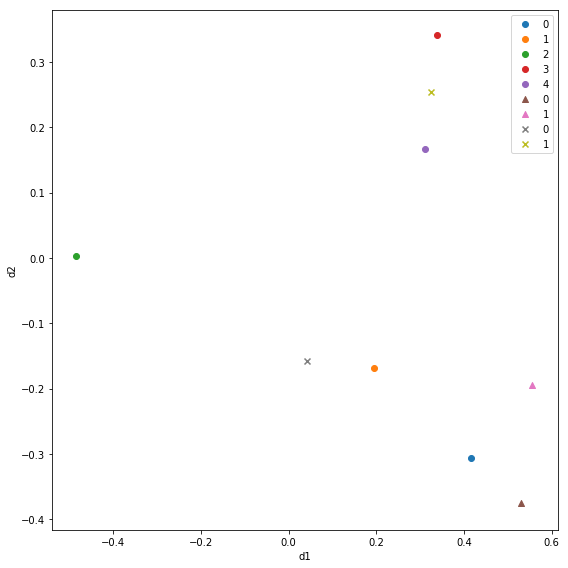

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
visualize(axes, Tt, [str(x) for x in range(0, Tt.shape[0])])
visualize(axes, Xt, [str(x) for x in range(0, Xt.shape[0])], marker='^')
visualize(axes, means, [str(x) for x in range(0, means.shape[0])], marker='x')
plt.tight_layout()
axes.legend()
plt.show()